IMPORTATION BIB + DONNEES

In [47]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, clear_output
import traitlets
import numpy as np

pd.set_option('display.max_rows', 500)

style = {'description_width': 'initial'}

df_loyer = pd.read_excel("data/loyer_par_metre_carre.xlsx")
df_loyer['Code'] = df_loyer['Code'].astype(str)

df_achat = pd.read_csv("data/communesdvf2024.csv")
df_achat['INSEE_COM'] = df_achat['INSEE_COM'].astype(str)

geo_dept = gpd.read_file("data/departements.geojson")
geo_dept['code'] = geo_dept['code'].astype(str)

NETTOYAGE DES DONNEES

In [48]:
condition_nettoyage = df_loyer["Loyer d'annonce"] == 'N/A - résultat non disponible'
indices_supp = df_loyer[condition_nettoyage].index
df_loyer = df_loyer.drop(indices_supp)

##Ajout colonne code département
df_loyer['code_dept'] = df_loyer['Code'].astype(str).str.slice(0, 2)
condition_nettoyage = (df_loyer['code_dept'] == '97') | (df_loyer['code_dept'] == '2A') | (df_loyer['code_dept'] == '2B')
indices_supp = df_loyer[condition_nettoyage].index
df_loyer = df_loyer.drop(indices_supp) #Supression des outre-mer et de la corse pour simplifier

##Ajout colonne code département
df_achat['code_dept'] = df_achat['INSEE_COM'].astype(str).str.slice(0, 2)
condition_nettoyage = (df_achat['code_dept'] == '97') | (df_achat['code_dept'] == '2A') | (df_achat['code_dept'] == '2B')
indices_supp = df_achat[condition_nettoyage].index
df_achat = df_achat.drop(indices_supp) #Supression des outre-mer et de la corse pour simplifier


TRAITEMENT REGROUPEE PAR FONCTION

création de la carte de france

In [49]:
def carte_rentabilite (df_loyer, df_achat, geo_dept):

    loyers_moyens_par_dept = df_loyer.groupby('code_dept')["Loyer d'annonce"].mean()
    df_dept = loyers_moyens_par_dept.reset_index()
    df_dept.columns = ['Numéro de département', 'Loyer moyen']

    prix_moyens_par_dept = df_achat.groupby('code_dept')["Prixm2Moyen"].mean()
            
    df_dept['Prix moyen'] = df_dept['Numéro de département'].map(prix_moyens_par_dept)

    df_dept['Rentabilité'] = ((df_dept['Loyer moyen']*12)/df_dept['Prix moyen'])*100

    ##Filtre des outliers car quelques valeurs aberantes

    Q1 = df_dept['Rentabilité'].quantile(0.25)
    Q3 = df_dept['Rentabilité'].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    df_dept_rentabilite = df_dept[(df_dept['Rentabilité'] >= lim_inf) & (df_dept['Rentabilité'] <= lim_sup)]

    df_top5 = df_dept_rentabilite.sort_values(by='Rentabilité', ascending=False).head(5)
    
    df_top5 = df_top5.merge(
        geo_dept[['code', 'nom']], 
        left_on='Numéro de département', 
        right_on='code', 
        how='left'
    )
    
    legend_items = ["Top 5 Rentabilité Brute:"]
    df_top5_reset = df_top5.reset_index() 
    for index, row in df_top5_reset.iterrows():
        item = f"{index + 1}. {row['nom']} ({row['Numéro de département']}) : {row['Rentabilité']:.2f}%"
        legend_items.append(item)
    legend_text = "\n".join(legend_items)

    carte_df = geo_dept.merge(
        df_dept_rentabilite, 
        left_on='code', 
        right_on='Numéro de département', 
        how='left'
    )

    carte_df['Loyer moyen'] = pd.to_numeric(carte_df['Loyer moyen'])
            
    carte_df['Rentabilité'] = carte_df['Rentabilité'].replace([np.inf, -np.inf], np.nan)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    carte_df.plot(
        ax=ax,
        color="lightgrey",
        edgecolor="0.8",
        linewidth=0.5
    )

    carte_avec_donnees = carte_df.dropna(subset=['Rentabilité'])

    carte_avec_donnees.plot(
        column='Rentabilité', 
        cmap='Reds',           
        linewidth=0.5,         
        ax=ax,                 
        edgecolor='0.8',     
        legend=True,
        legend_kwds={
            'label': "Rentabilité brute de la location (%)", # C'est 'title' qu'il faut ici
            'orientation': "horizontal",
            'shrink': 0.7 
        }
    )
            
    ax.set_axis_off() 
    ax.set_title(
        "Rentabilité brute moyenne par département en France", 
        fontdict={'fontsize': '16', 'fontweight' : '3'}
    )

    fig.text(0.25, 0.25, # Coordonnées (x, y) relatives à la figure (0,0 = bas gauche)
            legend_text,
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
            verticalalignment='bottom',
            horizontalalignment='left')

    plt.show()

    return df_dept_rentabilite

C:\Users\lulus\AppData\Local\Temp\ipykernel_24860\4172591477.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  carte_df['Rentabilité'] = carte_df['Rentabilité'].replace([np.inf, -np.inf], np.nan)


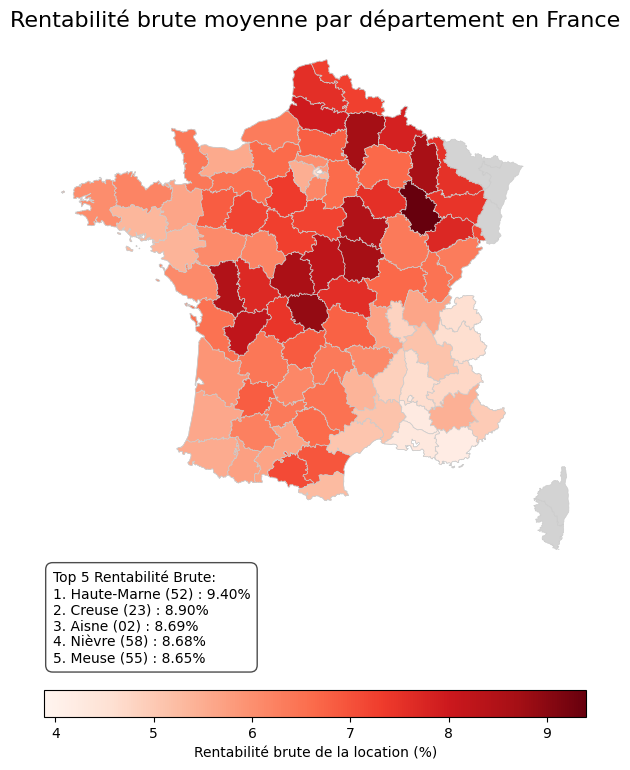

In [50]:
df_dept_rentabilite = carte_rentabilite(df_loyer, df_achat, geo_dept)

création courbe par département meilleures rentabilité de location en fonction du nombre de metre carré du bien

renta = (prix_loyer_moyen_m2 * 12)/prix_moyen_achat_m2

In [63]:
def calcul_rentabilite (prix_achat, loyer, nb_m2, dept, df_dept_rentabilite):
    
    if nb_m2 <= 0 or prix_achat <= 0:
        print("Erreur : Le prix d'achat et les m2 doivent être supérieurs à 0.")
        return
    
    prix_achat_m2 = prix_achat/nb_m2
    loyer_m2 = loyer/nb_m2
    rentabilite = ((loyer_m2*12)/prix_achat_m2)*100

    ligne_dept = df_dept_rentabilite[df_dept_rentabilite['Numéro de département'] == dept]
    renta_dept = ligne_dept['Rentabilité'].iloc[0]
    loyer_dept = ligne_dept['Loyer moyen'].iloc[0]

    ecart_relatif_rentabilite = ((rentabilite/renta_dept) - 1) * 100
    ecart_relatif_loyer = ((loyer_dept/loyer_m2)-1) * 100

    #figure
    categories = ['Rentabilité', 'Loyer']
    valeurs = [ecart_relatif_rentabilite, ecart_relatif_loyer]
    couleurs = []

    for v in valeurs:
        if v > 20:
            couleurs.append('green')
        elif v < -20:
            couleurs.append('red')
        else: 
            couleurs.append('orange') 

    fig, ax= plt.subplots()
    ax.barh(categories, valeurs, color=couleurs)

    for index, valeur in enumerate(valeurs):
        ax.text(valeur + 1, index, f"{valeur:+.0f}%", va='center', color='black')
    
    ax.axvline(0, color='black', linewidth=1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([]) # Cache l'axe X
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.title(f"Positionnement vs Moyenne du Dpt: {dept} (Rentabilité Dpt: {renta_dept:.2f}%, Loyer Dpt: {loyer_dept:.2f}€/m², Rentabilité Bien: {rentabilite:.2f}%, Loyer Bien: {loyer_m2:.2f}€/m²)")
    plt.show()

widgets.interact(calcul_rentabilite,
                 prix_achat=widgets.IntText(value=100000, description='Prix total du bien: ', style={'description_width': 'initial'}),
                 loyer=widgets.IntSlider(value = 484, min=100, max=10000, description='Prix du loyer souhaité: ', style={'description_width': 'initial'}, layout={'width': '80%'}),
                 nb_m2=widgets.IntText(value=40, description='Taille en m2 du bien: ', style={'description_width': 'initial'}),
                 dept=widgets.Text(value='01', description='Département: ', style={'description_width': 'initial'}),
                 df_dept_rentabilite=fixed(df_dept_rentabilite)
                 )


interactive(children=(IntText(value=100000, description='Prix total du bien: ', style=DescriptionStyle(descrip…

<function __main__.calcul_rentabilite(prix_achat, loyer, nb_m2, dept, df_dept_rentabilite)>